# Gaussian Mixture Model for cluster membership

This is a very basic example showing how we can identify a dense cluster of stars in the Gaia data, and get a list of its members.

First, we query Gaia data in a circular field of view around NGC 2506. To make things faster, I also impose a magnitude limit of 18, and the additional constrain that I only want sources with a proper motion:

In [1]:
%%time
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited

RA = 120.0
DEC = -10.76
RADIUS = 0.4

queryStringGaia = """select * from gaiadr3.gaia_source
                    where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',%.3f,%.3f,%.3f))
                    and phot_g_mean_mag<18 and pmra is not null""" % (RA,DEC,RADIUS)

job = Gaia.launch_job_async(queryStringGaia,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 4.65 s, sys: 351 ms, total: 5 s
Wall time: 7.71 s


Text(0, 0.5, 'G')

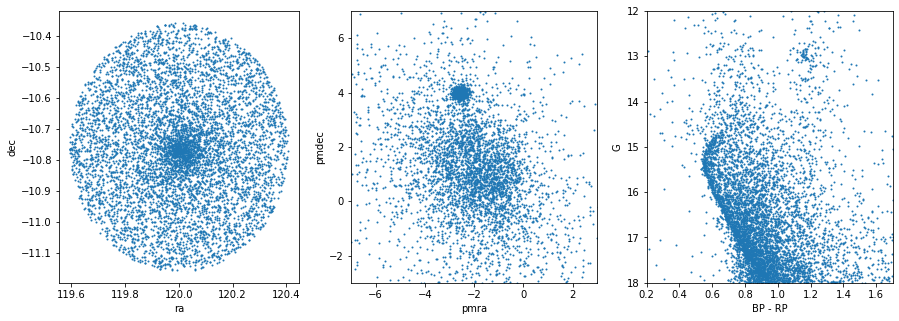

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure( figsize=(15,5))

plt.subplot(131,aspect= abs(1./np.sin(np.radians(RA))) )
plt.scatter( GaiaT['ra'] , GaiaT['dec'] , s=1 )
plt.xlabel('ra'); plt.ylabel('dec')

plt.subplot(132)
plt.scatter( GaiaT['pmra'] , GaiaT['pmdec'] , s=1 )
plt.xlim(-7,3); plt.ylim(-3,7)
plt.xlabel('pmra'); plt.ylabel('pmdec')

plt.subplot(133)
plt.scatter( GaiaT['bp_rp'] , GaiaT['phot_g_mean_mag'] , s=1 )
plt.xlim(0.2,1.7); plt.ylim(18,12)
plt.xlabel('BP - RP'); plt.ylabel('G')

The cluster is clearly visible in proper motion space. Let's use a GMM to model the proper motion distribution. In principle, the smallest component will be the cluster. 

**Remark 1:** by default, the initialisation of the search is random, so every time you will get slightly different results. 

**Remark 2:** if you only use two components, the procedure will use both of them to model the field. Even with three components, you will probably miss the cluster. With four or more, you start picking up the cluster every time.

In the following we fit and plot the results. We plot the small component in black, the others in blue:

Component 0
Mean: [-1.99237452  1.11288057] 
Covariance:
 [[ 2.00629019 -0.76382658]
 [-0.76382658  2.60180364]]
Weight: 0.49836420548568683


Component 1
Mean: [-2.77744531 -0.15721006] 
Covariance:
 [[18.82691832 -9.41638154]
 [-9.41638154 27.0957593 ]]
Weight: 0.2308203874487162


Component 2
Mean: [-143.66237006  -25.45386454] 
Covariance:
 [[146.51463687 128.37223705]
 [128.37223705 112.47634951]]
Weight: 0.000306607389238081


Component 3
Mean: [-2.56069424  3.9688911 ] 
Covariance:
 [[ 0.01151952 -0.00023127]
 [-0.00023127  0.00796959]]
Weight: 0.23812349531360372


Component 4
Mean: [ 46.02177998 -89.01205029] 
Covariance:
 [[202.5639239   80.08951951]
 [ 80.08951951  68.04639701]]
Weight: 0.0006125193928482073


Component 5
Mean: [-5.60186072 -5.98756653] 
Covariance:
 [[ 275.79836094 -118.35081811]
 [-118.35081811  353.38688854]]
Weight: 0.0317727849699073




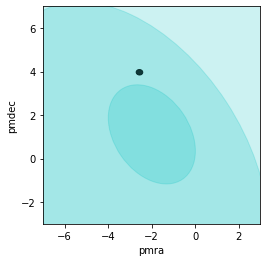

In [5]:
N_COMPONENTS = 6

from sklearn import mixture
from scipy import linalg #used to compute the ellipses
import matplotlib as mpl #used to plot the ellipses

X = np.array([GaiaT['pmra'] , GaiaT['pmdec']]).T
gmm = mixture.GaussianMixture(n_components=N_COMPONENTS, covariance_type="full").fit(X)

colorsToPlot = ["C0","C1","C2","C3","C4","C5"]
plt.figure() 
splot = plt.subplot(111,aspect=1 )
plt.xlim(-7,3); plt.ylim(-3,7)
plt.xlabel('pmra'); plt.ylabel('pmdec')

for iii in range(N_COMPONENTS):
    print('Component',iii)
    print( 'Mean:',gmm.means_[iii], '\nCovariance:\n', gmm.covariances_[iii] )
    print('Weight:',gmm.weights_[iii])
    print('\n')
    

    
    # get the ellipse from the covariance matrix:
    v, w = linalg.eigh(gmm.covariances_[iii])
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # plot it
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    
    if gmm.covariances_[iii][0][0] < 0.1:
        ell = mpl.patches.Ellipse(gmm.means_[iii], v[0], v[1], angle=180.0 + angle , color='k' )
        ell.set_alpha(0.9)
    else:
        ell = mpl.patches.Ellipse(gmm.means_[iii], v[0], v[1], angle=180.0 + angle , color='c' )
        ell.set_alpha(0.2)  
        
    splot.add_artist(ell)

After fitting, we can use `gmm.predict(X)` to assign every data point to one of the Gaussian components.

Text(0, 0.5, 'G')

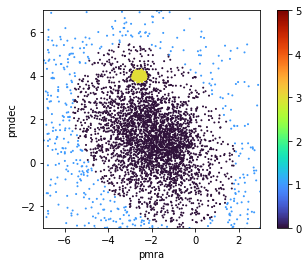

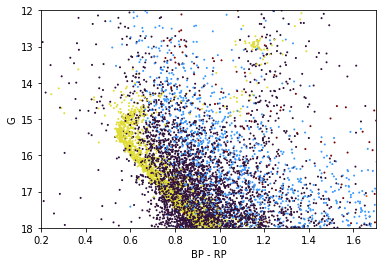

In [6]:
plt.figure()
plt.subplot(111,aspect=1)
plt.scatter( GaiaT['pmra'] , GaiaT['pmdec'] , s=1 , c=gmm.predict(X) , cmap='turbo')
plt.xlim(-7,3); plt.ylim(-3,7)
plt.xlabel('pmra'); plt.ylabel('pmdec')
plt.colorbar()

plt.figure()
plt.subplot(111)
plt.scatter( GaiaT['bp_rp'] , GaiaT['phot_g_mean_mag'] , s=1 , c=gmm.predict(X) , cmap='turbo' )
plt.xlim(0.2,1.7); plt.ylim(18,12)
plt.xlabel('BP - RP'); plt.ylabel('G')